# Objectives

1. Plot the RTT Linear Regression
1. Plot rate variation
1. Plot timetree

---
# Setup

## Import Modules

In [17]:
import os

import seaborn as sns
import matplotlib.pyplot as plt

import random
import json # Read clock model data
import scipy.stats # Regression line
import math

from Bio import Phylo

## Input File Paths

In [2]:
tree_tt_path = "../../docs/results/latest/timetree/timetree.nwk"
tree_df_path = "../../docs/results/latest/timetree/timetree.tsv"
clock_model_path = "../../docs/results/latest/timetree/timetree_clock_model.json"
augur_json_path = "../../docs/results/latest/timetree/timetree_augur.json"

outdir = "../../docs/results/latest/timetree/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "timetree"

# Random
random.seed(1152342, 2)
np.random.seed(70262122)
st0 = np.random.get_state()


plt.rc('lines', linewidth=2)
plt.rc('legend', labelspacing=0.75)
plt.rc('legend', frameon=False) # legend frame

## Import Dataframe

In [4]:
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

In [5]:
## Import Trees

In [6]:
tree_tt = Phylo.read(tree_tt_path, "newick")
tree_tt.ladderize(reverse=False)

---
# 1. Plot RTT Regression

In [7]:
with open(augur_json_path) as infile:
    augur_json = json.load(infile)
    regression = augur_json["clock"]
    print(regression)

{'intercept': 4.781671248458715e-05, 'rate': 9.714808605351293e-09, 'rtt_Tmrca': -4922.04369916746}


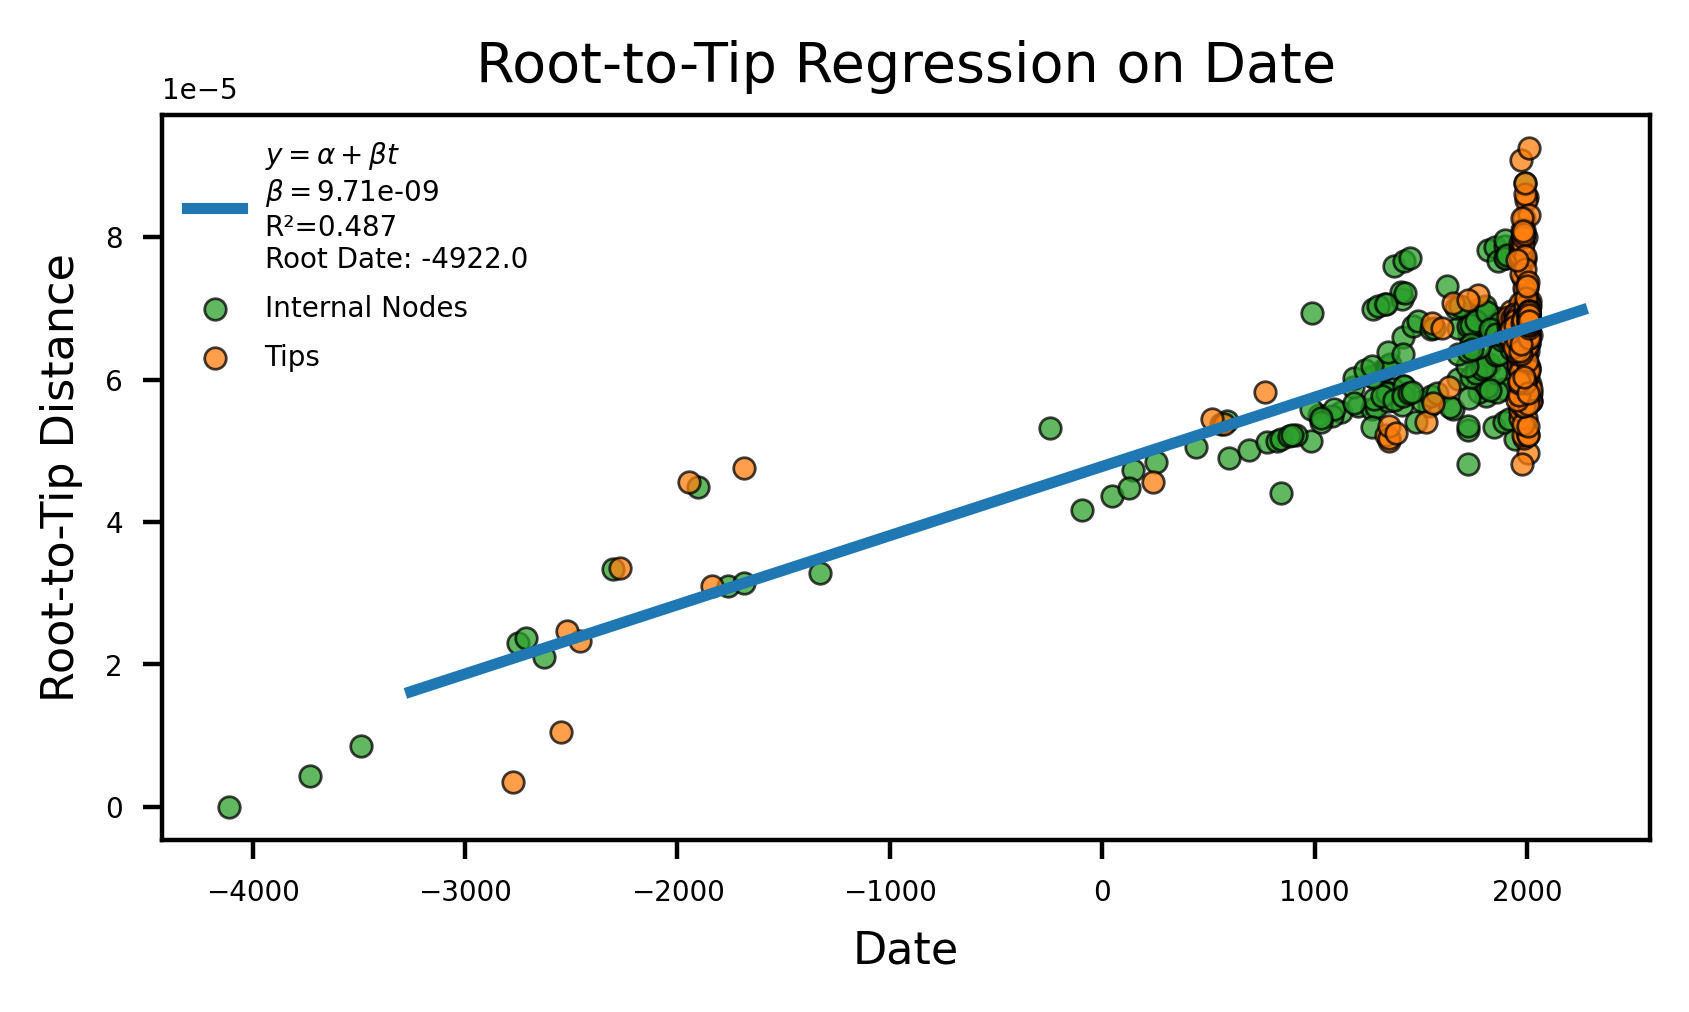

In [8]:
# Setup axis
fig, (ax1) = plt.subplots(1, dpi=dpi, figsize=figsize_mini)


# Make separate datasets for tips and internal nodes
tip_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) &
                   (tree_df["Branch_Support_Color"] == TERM_COL) ]

int_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] != TERM_COL)]

# Time to most recent common ancestor (x-intercept)
t_mrca = -regression['intercept']/regression['rate']

# This does not filter for bad branches!
time_span = np.max(tip_data["timetree_reg_x"]) - np.min(tip_data["timetree_reg_x"])
x_vals = np.array([max(np.min(tip_data["timetree_reg_x"]), t_mrca) - 0.1*time_span, 
                   np.max(tip_data["timetree_reg_x"]+0.05*time_span)])

res = scipy.stats.linregress(list(tip_data["timetree_reg_x"]),list(tip_data["timetree_reg_y"]))

# When no confidence is enabled
dev_rtt = None
dev_slope = None

# Plot internal nodes
ax1.scatter(data=int_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Internal Nodes",
            color=DISC_CMAPLIST[2],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=1,)
# Plot tips
ax1.scatter(data=tip_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Tips",
            color=DISC_CMAPLIST[1],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=2,)

# Regression line
ax1.plot(x_vals, 
         regression['rate']*x_vals + regression['intercept'],
         label = r"$y=\alpha + \beta t$"+"\n"+
                r"$\beta=$%1.2e"%(regression["rate"])
                + ("+/- %1.e"%dev_slope if dev_slope else "") +
                "\nR²={:.3f}".format(res.rvalue**2) +
                "\nRoot Date: %1.1f"%(-regression['intercept']/regression['rate']) +
                ("+/- %1.2f"%dev_rtt if dev_rtt else ""),
         color=DISC_CMAPLIST[0],
         zorder=3,
        )

# Labels
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")
ax1.set_title("Root-to-Tip Regression on Date")
# Legend
plt.legend(loc=2)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

---
# 2. Plot Rate Variation

'\n# Save\nout_path = os.path.join(outdir, SCRIPT_NAME + "_rate_variation." + FMT) \nplt.savefig(out_path, \n        dpi=dpi, \n        bbox_inches = "tight")'

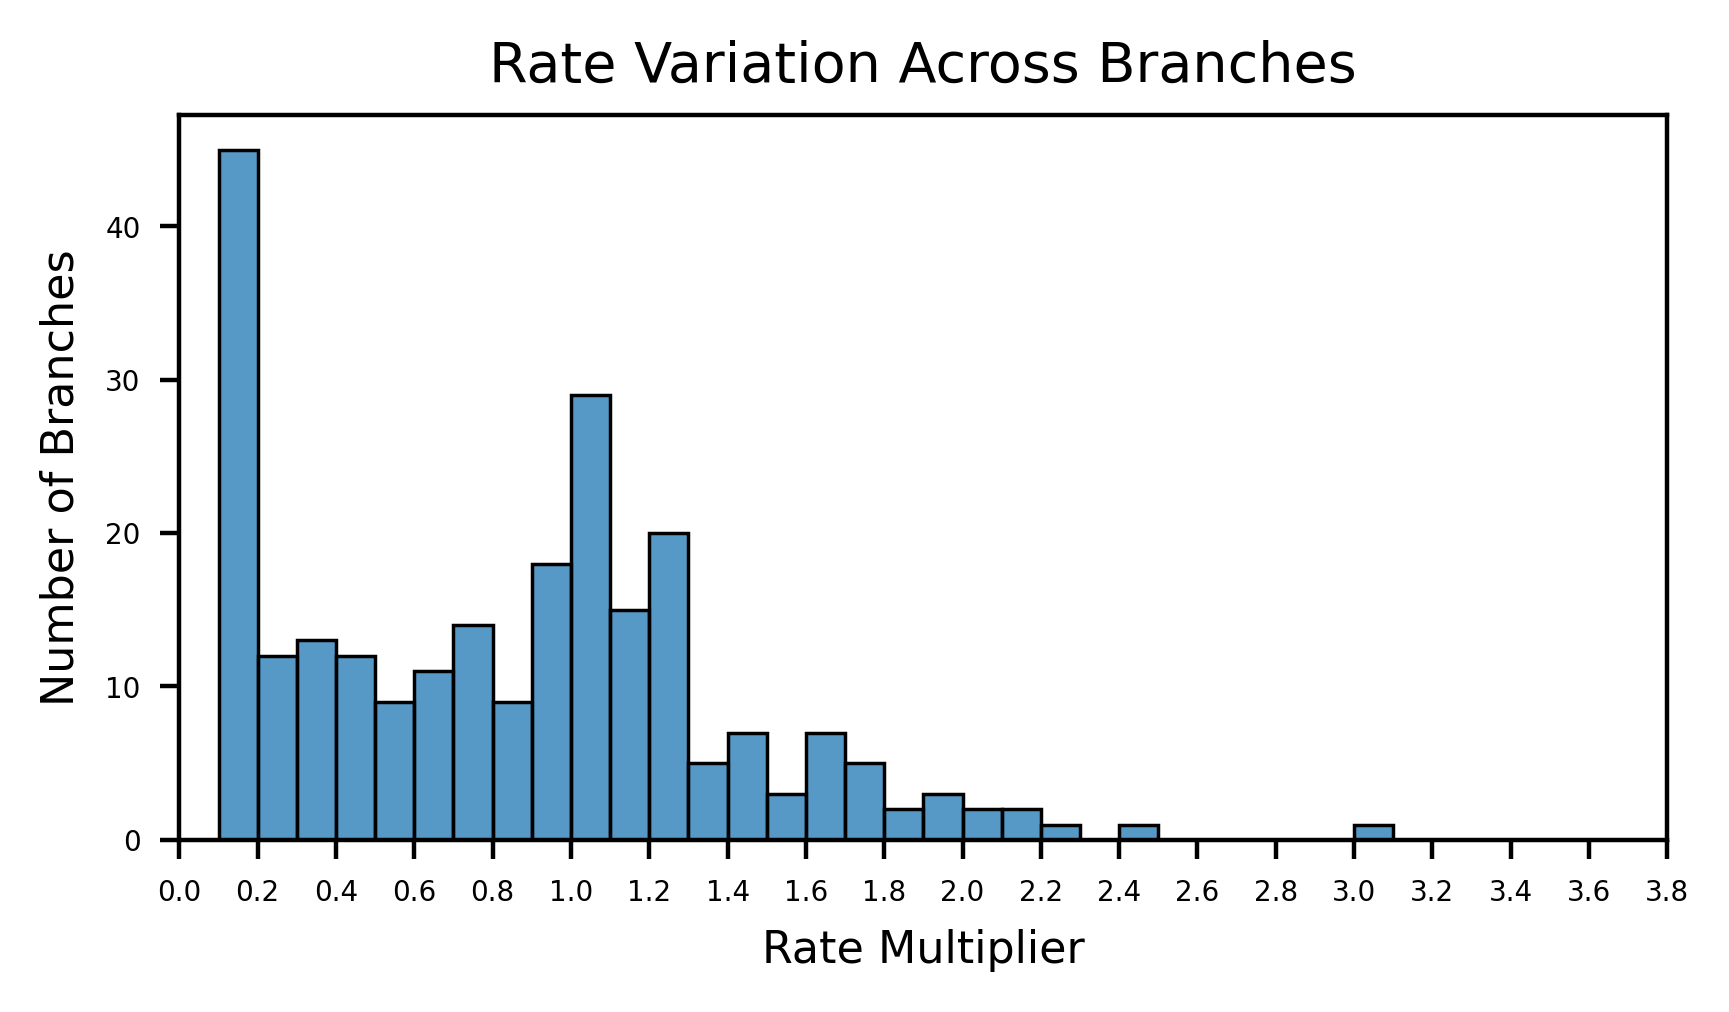

In [34]:
# Setup axis
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize_mini)

# Plot the histogram
# troubleshoot the disappearing nodes!

min_gamma = ['', 1]
max_gamma = ['', 1]
gamma_dict = {}
    
for rec in tip_data.iterrows():
    sample = rec[0]
    data = rec[1]
    g = tip_data["timetree_rate_fold_change"][sample]
    if g <= min_gamma[1]:
        min_gamma[0] = sample
        min_gamma[1] = g
    if g >= max_gamma[1]:
        max_gamma[0] = sample
        max_gamma[1] = g
    gamma_dict[sample] = g

# Bins and Ticks
int_max_gamma = math.ceil(max_gamma[1])
hist_bins = [x/10 for x in range(0,int_max_gamma * 10, 1)]
xticks_major = [x/10 for x in range(0, int_max_gamma * 10, 2)]

sns.histplot(x = list(gamma_dict.values()), 
         ax=ax1,
         alpha=0.75,
         bins=hist_bins,
         ) 

        
ax1.set_xlabel("Rate Multiplier")
ax1.set_ylabel("Number of Branches")
ax1.set_xlim(0,max_gamma[1])
ax1.set_title("Rate Variation Across Branches")

ax1.set_xticks(xticks_major)

"""
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rate_variation." + FMT) 
plt.savefig(out_path, 
        dpi=dpi, 
        bbox_inches = "tight")"""

---
# 3. Plot Timetree

NameError: name 'MUG_ATTR' is not defined

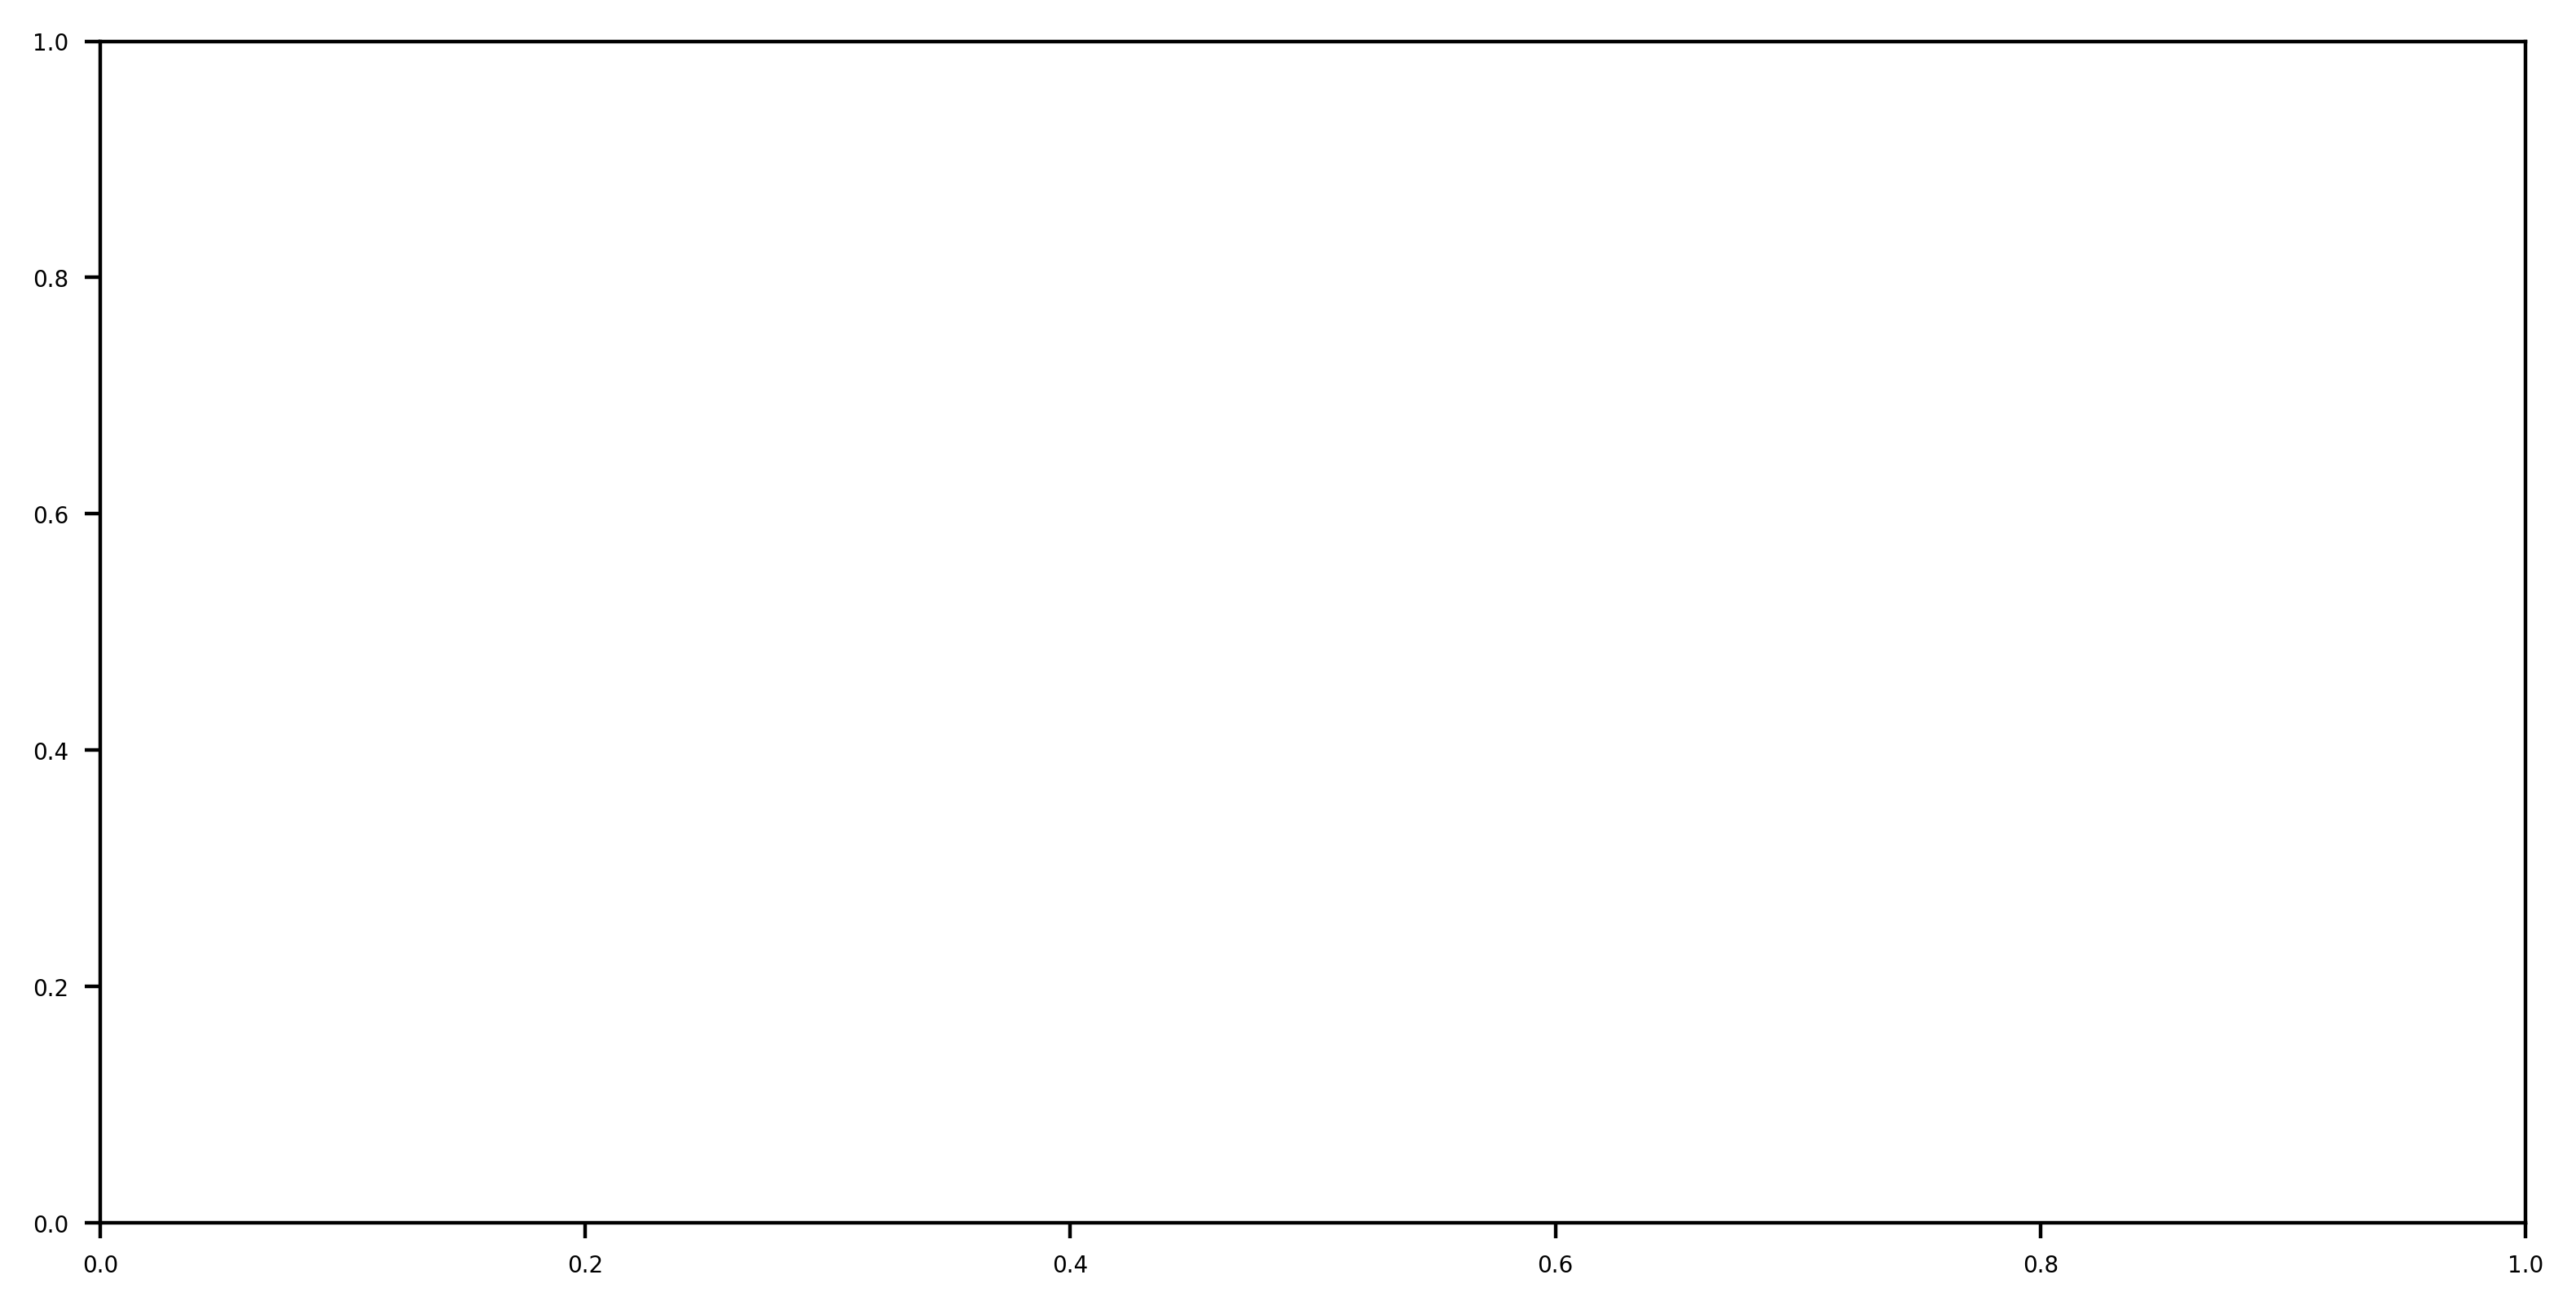

In [10]:
fig, (ax1) = plt.subplots(1, 
                         dpi=dpi, 
                         gridspec_kw={'wspace': 0.05}, 
                         figsize=figsize_alt,
                         sharey=True,
                         )

plt.rc('lines', linewidth=0.5)

# Create a dictionary to hold mapping of attribute : color
# Will need this later for legend construction?
mug_dict = {MUG_ATTR: {"hex_color": {}}}

# Make copies for modification
tree_div_copy = copy.deepcopy(tree_div)
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

for c in tree_div_copy.find_clades():
    c.color = "black"
# --------------------------------------------
# Draw trees
for t,ax in zip([tree_div_copy, tt_copy.tree], [ax1, ax2]):
    # Color the tree by an attribute
    hex_dict = color_tree(tree=t, 
                          df=tree_df, 
                          attribute="Mugration_" + MUG_ATTR,
                          attribute_confidence="Mugration_" + MUG_ATTR + "_Confidence",
                          threshold_confidence=MUG_CONF_THRESH,                          
                          color_pal=CONT_COLOR_PAL)
    # Add the Low confidence Element
    hex_dict["Low Confidence"] = "grey"
    mug_dict[MUG_ATTR]["hex_color"] = hex_dict
    Phylo.draw(t, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)